In [6]:
# Merger rate for IMRIPY system when they throw away all of the dark matter before merging.

import numpy as np
import matplotlib.pyplot as plt
import imripy
from imripy import merger_system as ms
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from numpy import diff
import mass_function
from sympy import *
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})
   


π = np.pi
Ω_cdm = 0.85
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1808e3           #in units of M☉ pc^-3 with ρ_eq=2.1548e-16 kg m^-3
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.5923e12/yr      # in units of seconds
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
t_0 = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr

σ_eq = 0.005
ρ_m = 4e19                #ρ_m = 4e19 M☉ Gpc^-3
year_to_pc = 0.3064


   
N = 100
m_2 = np.geomspace(1e-4, 100, N)    
m_2_list = m_2.tolist()

bin_centres = np.geomspace(1e-4, 100, N)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])
ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 
deltas = np.diff(bin_edges)
Δ_2_list = deltas.tolist()

Δ_1 =  Δ_2_list[-1]  # for m_1 = 30 M_solar

m_1 = 100    #in units of solar mass.
a_i = 0.01  #in units of pc
j_i = 1e-3

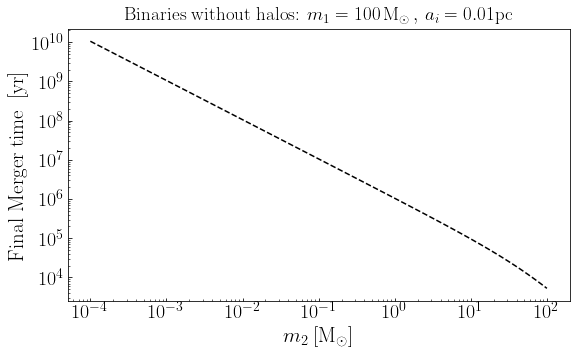

In [7]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


def final_merger_time_nohalos(m_2):  # assuming a_i = a_f and hence j_i = j_f .
    a_f = a_i
    
    def t_merge_initial(m_1, m_2):
        return (3/85) * (((a_i**4) * (c**5) * (j_i**7))/((G**3)* m_1 * m_2 * (m_1 + m_2)))
    
    return   ((a_f/a_i)**(1/2)) * t_merge_initial(m_1, m_2)



final_merger_time_nohalos_list = np.zeros(len(m_2_list))

for i, m_2 in enumerate(m_2_list):
    final_merger_time_nohalos_list[i] = final_merger_time_nohalos(m_2)
    
    
plt.figure(figsize=(9, 5))

plt.loglog(m_2_list, final_merger_time_nohalos_list, 'k', linestyle = '--')

np.save('final_merger_time_nohalos_list.npy', final_merger_time_nohalos_list)          
 

plt.xlabel('$m_{2}\:\mathrm{[M_{\odot}]}$', fontsize = 21)
plt.ylabel('Final Merger time $\: \mathrm{[yr]}$', fontsize = 21)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title(r'Binaries without halos: $m_{1} = 100 \, \mathrm{M_{\odot}} \,,\, a_{i} = 0.01 \mathrm{pc}$', fontsize = 19, pad = 9)
plt.show()     

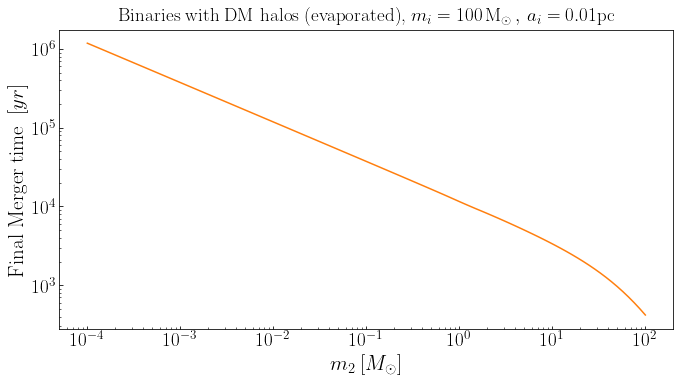

In [8]:
def final_merger_time_evaporatedhalos(m_2, Δ_2):  # j_f = sqrt(a_i/a_f) * j_i
    
    f_pbh = mass_function.f_PBH
    f =  f_pbh*0.85
            
    m_min = 1e-4
    m_max = 100

    def P(m):    #in units of M☉, for PBHs mass range of m_min = 1e-4 M☉ - m_max = 100 M☉ 
        return mass_function.new_PDF(m)

    
    def f_(m):
        return f*P(m)

    def f_b(m_1, m_2):
        return  f_(m_1) + f_(m_2)

    def x̄(m_1,m_2,Δ_1,Δ_2):   
        return (((3 * (m_1 + m_2))/(4 * π * ρ_eq * f_b(m_1, m_2) * np.sqrt(Δ_1 * Δ_2)))**(1/3))

    
    
    def λ(m_1, m_2, Δ_1, Δ_2):  # using x = x_bar
        λ = Symbol('λ')
        roots = solve(λ**2 + (0.0977/0.0068) * λ + ((0.0977/0.0068) * (a_i/x̄(m_1,m_2,Δ_1,Δ_2))), λ)
        return roots[1]
        
    def s(m_1, m_2,Δ_1,Δ_2): # S_dec of the binary decouple.
        return ( (0.03062*λ(m_1, m_2,Δ_1,Δ_2)+ 0.3425) * λ(m_1, m_2,Δ_1,Δ_2) )

    
    def t_dec(m_1, m_2, Δ_1, Δ_2):  #t_dec of the binary decouple.
        return np.sqrt(2) * (np.sqrt(3/(8*π*G*ρ_eq))) * (((2/3)*(s(m_1, m_2, Δ_1, Δ_2)-2)* ((s(m_1, m_2, Δ_1, Δ_2)+1)**(1/2)))+(4/3))

    
    def ρ_bar(m):
        return Ω_cdm * (ρ_eq/2)* (t_eq**(3/2)) * ((2*G*m)**(3/4)) 
    
    def M_1halo(m_1, m_2,Δ_1,Δ_2):
        return (((16*π)/3)*ρ_bar(m_1)*((2*G*m_1*(t_dec(m_1, m_2,Δ_1,Δ_2)**2))**(1/4)))
    
    
    def M_2halo(m_1, m_2,Δ_1,Δ_2):
        return (((16*π)/3)*ρ_bar(m_2)*((2*G*m_2*(t_dec(m_1, m_2,Δ_1,Δ_2)**2))**(1/4)))
    

    def M_binary_initial(m_1, m_2,Δ_1,Δ_2):
        return (m_1 + m_2 + M_1halo(m_1, m_2,Δ_1,Δ_2) + M_2halo(m_1, m_2,Δ_1,Δ_2))
      
    def M_1(m_1, m_2,Δ_1,Δ_2):
        return (m_1 + M_1halo(m_1, m_2,Δ_1,Δ_2))
    
    def M_2(m_1, m_2,Δ_1,Δ_2):
        return (m_2 + M_2halo(m_1, m_2,Δ_1,Δ_2))
    

    #Schwarzchild Radius of the PBH.
    def r_s(m): 
        return ((2*G*m)/(c**2)) 


    #r_turnaround of the dark matter halos, eq.(5) in "WIMPs and stellar-mass primordial black holes are incompatible"
    def r_ta(m): 
        return ((2*G*m*(t_dec(m_1, m_2,Δ_1,Δ_2)**2))**(1/3))


    # The binding energy, E_b of the dark matter halos calculated within r_s and r_ta for dark matter halo's density profile of ρ(r)∝ r^{-9/4}
    def E_b(m): 
        return ((16*π*G*ρ_bar(m)*m*(((r_ta(m))**(-1/4))-((r_s(m))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(m)**2)*(((r_ta(m))**(1/2))-((r_s(m))**(1/2)))))
   
    
    def a_final(m_1,m_2,Δ_1,Δ_2):
        return ((G* m_1 * m_2 * a_i)/((G * M_1(m_1, m_2,Δ_1,Δ_2) * M_2(m_1, m_2,Δ_1,Δ_2))-(2 * a_i *(E_b(m_1)+E_b(m_2)))))
     
    def t_merge_initial(m_1, m_2):
        return (3/85) * (((a_i**4) * (c**5) * (j_i**7))/((G**3)* M_1(m_1, m_2,Δ_1,Δ_2) * M_2(m_1, m_2,Δ_1,Δ_2) * (M_1(m_1, m_2,Δ_1,Δ_2) + M_2(m_1, m_2,Δ_1,Δ_2))))
    
    
    return   ((a_final(m_1, m_2,Δ_1,Δ_2)/a_i)**(1/2)) * t_merge_initial(m_1, m_2)





final_merger_time_evaporatedhalos_list = np.zeros(len(m_2_list))

for i, (m_2, Δ_2) in enumerate(zip(m_2_list,  Δ_2_list)):
    final_merger_time_evaporatedhalos_list[i] = final_merger_time_evaporatedhalos(m_2,Δ_2)

np.save('final_merger_time_evaporatedhalos_list.npy', final_merger_time_evaporatedhalos_list)          
    
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.figure(figsize=(11, 5.5))
plt.loglog(m_2_list, final_merger_time_evaporatedhalos_list, 'C1')
plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 21)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 21)
plt.xticks(fontsize = 19)
plt.yticks(fontsize = 19)
plt.title(r'Binaries with DM halos (evaporated), $m_{i} = 100 \, \mathrm{M_{\odot}} \, , \, a_{i} = 0.01 \mathrm{pc}$', fontsize = 19, pad = 9)
plt.show()     

/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:534: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t_coal = t_coal * 48./19. / g(e_0)**4 * quad(lambda e: g(e)**4 *(1-e**2)**(5./2.) /e/(1. + 121./304. * e**2), 0., e_0, limit=100)[0]   # The inspiral time according to Maggiore (2007)


Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.7321s
i = 0
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.6589s
i = 1
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.5539s
i = 2
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.5530s
i = 3
Evolving from  3

/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return -32./5. * sp.m_reduced(a)**2 * sp.m_total(a)**3 / a**5  / (1. - e**2)**(7./2.) * (1. + 73./24. * e**2 + 37./96. * e**4)
/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:337: RuntimeWarning: invalid value encountered in double_scalars
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:335: RuntimeWarning: invalid value encountered in sqrt
  v_s = np.sqrt(sp.m_total(a) *(2./r - 1./a))
/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/halo.py:321: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(r > self.r_min, self.rho_spike * (self.r_spike/r)**self.alpha, 0.)
/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:337: IntegrationWa

A termination event occurred.
 -> Evolution took 2.5663s
i = 17
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.5603s
i = 18
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.5769s
i = 19
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.6612s
i = 20
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A terminatio

/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:172: RuntimeWarning: invalid value encountered in double_scalars
  return -32./5. * sp.m_reduced(a)**2 * sp.m_total(a)**(5./2.) / a**(7./2.)  / (1. - e**2)**2 * (1. + 7./8.*e**2)


A termination event occurred.
 -> Evolution took 2.5637s
i = 33
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.5913s
i = 34
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.6297s
i = 35
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.6533s
i = 36
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A terminatio

/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:361: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Evolution took 3.2994s
i = 78
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 6.9741s
i = 79
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 14.2964s
i = 80
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 7.5064s
i = 81
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A terminati

/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:361: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Evolution took 206.2187s
i = 85
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 250.1653s
i = 86
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 257.2299s
i = 87
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 269.0533s
i = 88
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A te

/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  return 4.*np.pi * sp.m2**2 * sp.halo.density(r) * Classic.dmPhaseSpaceFraction * ln_Lambda / v**2
/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:336: RuntimeWarning: invalid value encountered in double_scalars
  return F(sp, r, v_s, opt)*v_s / (1.+e*np.cos(phi))**2
/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:337: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return -(1.-e*

A termination event occurred.
 -> Evolution took 273.7042s
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
The solver successfully reached the end of the integration interval.
 -> Evolution took 0.3019s
i = 95
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 292.2604s
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
The solver successfully reached the end of the integration interval.
 -> Evolution took 0.2771s
i = 96
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False

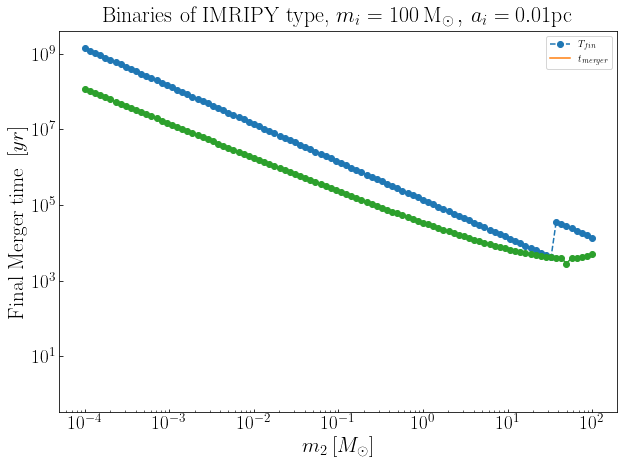

In [9]:
tm_static_halos_list_modified = np.zeros(len(m_2_list))
T_list = np.zeros(len(m_2_list))



for i, (m_2, Δ_2) in enumerate(zip(m_2_list,  Δ_2_list)):
    m_bar = m_1
    M_1 =  m_1 * ms.solar_mass_to_pc  
    M_2 =  m_2 * ms.solar_mass_to_pc 
    
    
    D_luminosity = 0              
    ρ_bar = Ω_cdm * (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1      # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    
    sp = ms.SystemProp(M_1, M_2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution
    

    e_i  = (1 - (j_i **2))**(1/2)
    
    def t_merge_initial(m_1, m_2):
        return (3/85) * (((a_i**4) * (c**5) * (j_i**7))/((G**3)* m_1 * m_2 * (m_1 + m_2)))
    
    tm = t_merge_initial(m_1, m_2)
    
    m_2_ref = 1 # in units of solar mass
    T = 1e-5 * (t_m * ms.year_to_pc ) * ((m_2/m_2_ref)**(-1))
    T_list[i] =  T/ms.year_to_pc
    
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i, e_i,  a_fin = R_fin, t_fin = T)
    tm = ev_ecc.t[-1]
    tm_static_halos_list_modified[i] = tm/ms.year_to_pc
    print("i =", i)
      
    
    while np.isclose(T_list[i], tm_static_halos_list_modified[i]) == True: 
        T_list[i] = T_list[i] * 10 
        ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i, e_i,  a_fin = R_fin, t_fin = T_list[i]*ms.year_to_pc)
        tm_static_halos_list_modified[i] = ev_ecc.t[-1]/ms.year_to_pc
        
            
    
print("T_list =", T_list, "yr")  
print("tm_list =", tm_static_halos_list_modified, "yr")
np.save('tm_static_halos_list_modified.npy', tm_static_halos_list_modified)          

    
plt.figure(figsize = (10, 7))    
plt.loglog(m_2_list, T_list, '--o', 'C1')     
plt.loglog(m_2_list, tm_static_halos_list_modified, '-o', 'C2')
plt.xticks(fontsize = 19)  
plt.yticks(fontsize = 19) 
plt.legend(["$T_{fin}$","$t_{merger}$"])
    

plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 21)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 21)
plt.title('Binaries of IMRIPY type, $m_{i} = 100 \, \mathrm{M_{\odot}} \, , \, a_{i} = 0.01 \mathrm{pc}$', fontsize = 22, pad = 9)
plt.savefig('tm_imripy.pdf', bbox_inches='tight')
plt.show()     

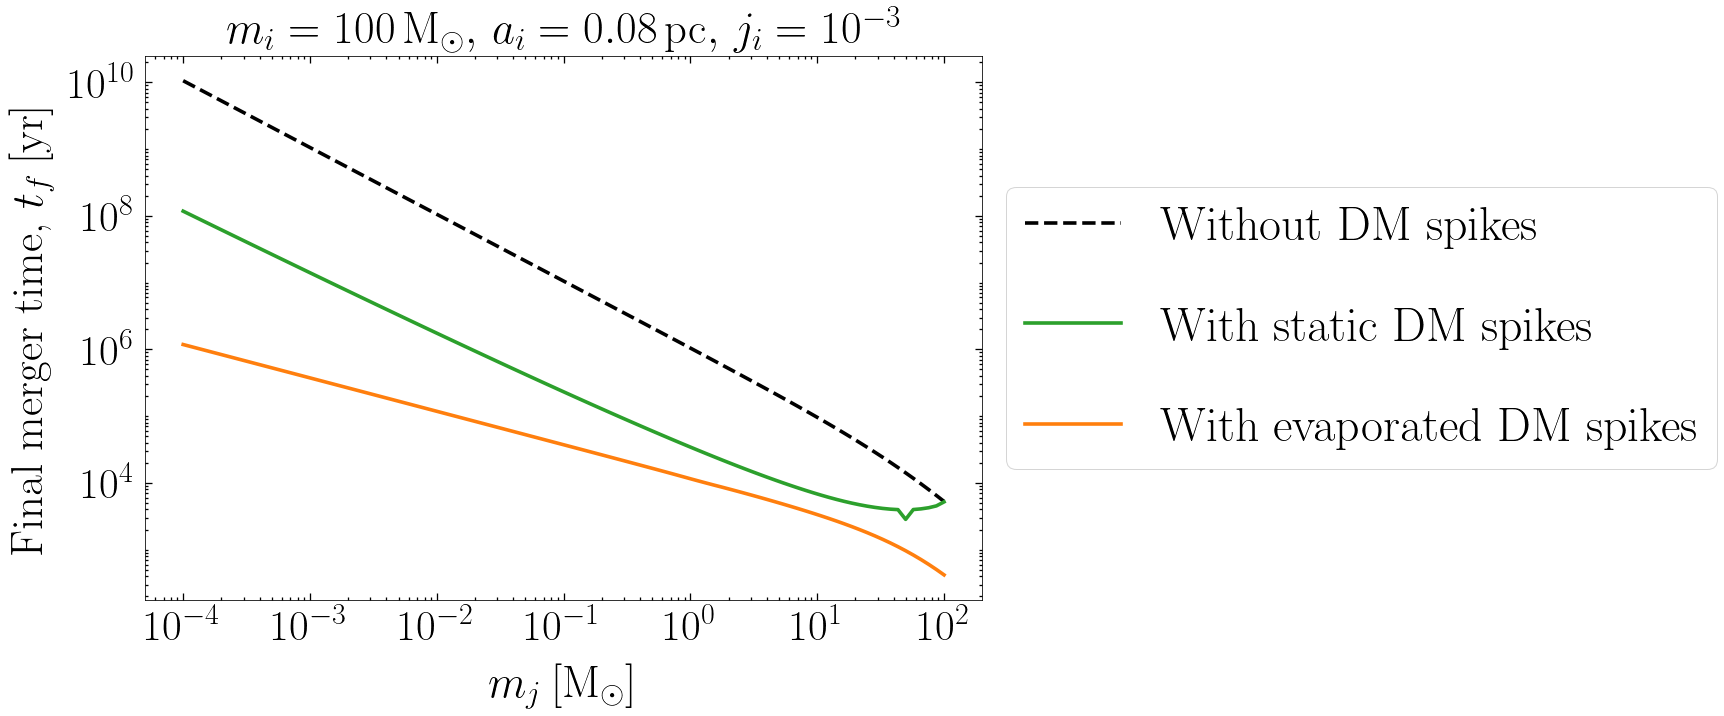

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imripy
from imripy import merger_system as ms
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from numpy import diff
import matplotlib as mpl
import matplotlib.ticker as mticker
import mass_function
from sympy import *
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
}) 


tm_static_halos_list_modified = np.load('tm_static_halos_list_modified.npy')
final_merger_time_evaporatedhalos_list = np.load('final_merger_time_evaporatedhalos_list.npy')
final_merger_time_nohalos_list = np.load('final_merger_time_nohalos_list.npy')




fig, ax = plt.subplots(1, figsize=(15, 10))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.3, length = 3)
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.3, length = 6.7)



ax.loglog(m_2_list, final_merger_time_nohalos_list, 'k--')
ax.loglog(m_2_list, tm_static_halos_list_modified,  'C2' )
ax.loglog(m_2_list, final_merger_time_evaporatedhalos_list,  'C1')


ax.yaxis.set_major_locator(mticker.LogLocator(numticks= 8))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks= 18, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.xaxis.set_major_locator(mticker.LogLocator(numticks= 8))
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks= 18, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


ax.tick_params(axis='x', pad= 9.7)
ax.tick_params(axis='y', pad= 9.7)


plt.rc('lines', linewidth = 3.6)
plt.xticks(fontsize = 43)
plt.yticks(fontsize = 43)

#plt.xlim(6e-5, 200)
#plt.ylim(1000, 1e11)


plt.legend(["Without DM spikes",  "With static DM spikes", "With evaporated DM spikes"], prop = {'size':48}, 
           loc = 'center left',  facecolor = 'white', fontsize = 40, labelspacing = 1.2,bbox_to_anchor=(1, 0.5))


plt.setp(ax.get_legend().get_texts(), fontsize='48')

plt.xlabel('$m_{j}\:[\mathrm{M_{\odot}}]$', fontsize = 45, labelpad = 15)
plt.ylabel('Final merger time, $ t_{f}\: [\mathrm{yr}]$', fontsize = 45, labelpad = 15)
plt.title(r'$m_{i} = 100 \, \mathrm{M_{\odot}}, \,  a_{i} = 0.08 \, \mathrm{pc}, \, j_{i} = 10^{-3}$', fontsize = 45, pad = 13)
plt.savefig('finalmergertime.pdf', bbox_inches = 'tight')
plt.show()